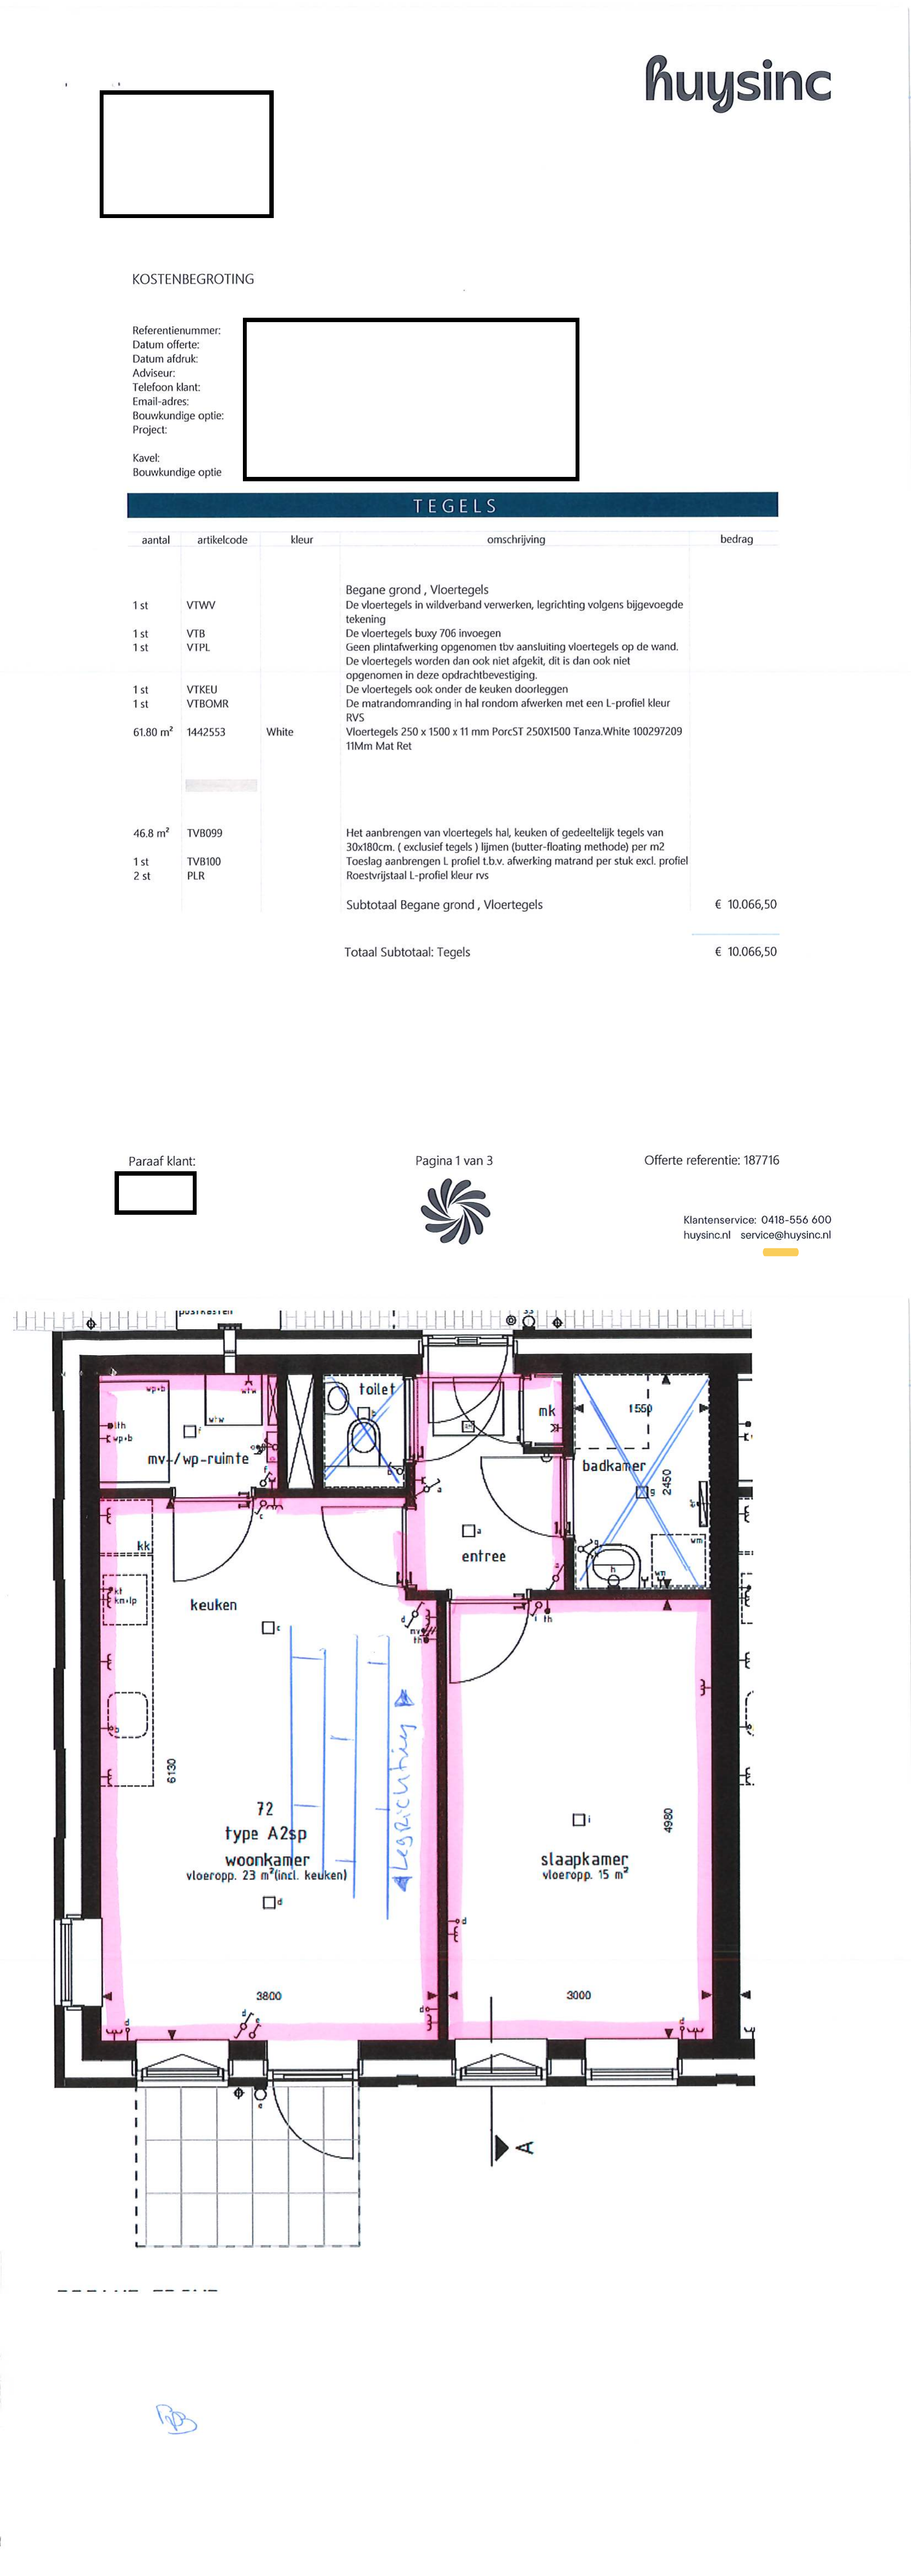

In [1]:
from textgrad.autograd import MultimodalLLMCall
from textgrad.loss import ImageQALoss
from pdf2image import convert_from_path
from dotenv import load_dotenv
from PIL import Image
import textgrad as tg
import numpy as np
import io


pdf_path = "pdf/187716-1 Klantorder definitief.pdf"

# Convert pages of the PDF to images
images = convert_from_path(pdf_path)
page_2 = images[2]  # Page 2
page_5 = images[5]  # Page 5
combined_width = max(page_2.width, page_5.width)
combined_height = page_2.height + page_5.height
combined_image = Image.new("RGB", (combined_width, combined_height), "white")
combined_image.paste(page_2, (0, 0))  # Paste page 2 at the top
combined_image.paste(page_5, (0, page_2.height))  # Paste page 5 below page 2
combined_buffer = io.BytesIO()
combined_image.save(combined_buffer, format='PNG')
combined_image_data = combined_buffer.getvalue()

# Open the combined image 
Image.open(io.BytesIO(combined_image_data))


# TextGrad

In [2]:
load_dotenv()
tg.set_backward_engine("gpt-4o", override=True)

### 1e response

In [3]:
image_variable = tg.Variable(combined_image_data, role_description="image with a table and a construction drawing, both in Dutch", requires_grad=False) # grad (nog) niet mogelijk bij images
question_string = "Try to detect which part in the table contains info about which part of the construction image. Only include what part of the table concerns what part of the drawing"
question_variable = tg.Variable(question_string, role_description="Compare", requires_grad=True)

response = MultimodalLLMCall("gpt-4o")([image_variable, question_variable])
print(response.value)

The table in the document provides details about floor tiles, which relate to the flooring in the construction drawing. Here's how they correspond:

1. **Begane grond, Vloertegels**: This refers to the ground floor tiles, which would be applied throughout the main areas shown in the floor plan, such as the woonkamer (living room), keuken (kitchen), and slaapkamer (bedroom).

2. **Vloertegels 250 x 1500 x 11 mm**: These specific tiles are likely used in the main living areas, as indicated in the floor plan.

3. **Het aanbrengen van vloertegels hal, keuken of gedeeltelijk tegels van 30x60/80cm**: This describes the application of tiles in the hall and kitchen, which are marked in the floor plan.

The table provides a cost estimate for these tiles, which are to be installed in the areas shown in the floor plan.


### Loss functie

TextGrad: "Keeping on the analogy with PyTorch, the optimizer in TextGrad is the object that will update the parameters of the model. In this case, the parameters are the variables that have requires_grad set to True."

In [6]:
# Define a natural-language specified loss function that describes how we want to evaluate the reasoning

loss_fn = ImageQALoss(
    evaluation_instruction="Does this seem like an extensive and complete answer? Criticize. Do not provide a new answer.",
    engine="gpt-4o"
)
loss = loss_fn(question=question_variable, image=image_variable, response=response)
loss

Variable(value=The answer attempts to connect the table entries to specific areas in the construction drawing, but it lacks clarity and specificity. Here are some points of criticism:

1. **Generalization**: The answer makes broad connections between the table and the drawing without specifying how each entry directly relates to the drawing's details.

2. **Lack of Specificity**: It mentions areas like the "woonkamer" and "keuken" but doesn't clearly explain how the table's entries correspond to these areas in terms of layout or dimensions.

3. **Cost Analysis**: The explanation of cost analysis is vague. It doesn't detail how the costs are calculated or how they relate to the specific areas in the drawing.

4. **Missing Details**: The answer doesn't address all entries in the table or how they might relate to other parts of the drawing, such as the "toilet" or "badkamer."

Overall, the answer could be improved by providing a more detailed and precise mapping of table entries to specif

### Optimized response

In [5]:
# Bereken gradients van de loss en optimize response

optimizer = tg.TGD(parameters=[response])
loss.backward() # Bereken 'gradients' van de loss tov response
optimizer.step() # Updates response
print(response.value)

The table in the document provides detailed information about floor tiles, which correspond to specific areas in the construction drawing. Here's a breakdown of how they relate:

1. **Begane grond, Vloertegels**: These tiles are designated for the ground floor, specifically covering the woonkamer (living room), keuken (kitchen), and slaapkamer (bedroom) as shown in the floor plan. The table indicates these areas will use the specified tiles.

2. **Vloertegels 250 x 1500 x 11 mm**: These tiles are intended for the main living areas, such as the woonkamer and keuken. The dimensions suggest they are suitable for larger spaces, providing a seamless look.

3. **Het aanbrengen van vloertegels hal, keuken of gedeeltelijk tegels van 30x60/80cm**: This entry specifies the application of tiles in the hall and kitchen. The floor plan highlights these areas, and the table details the tile sizes for these specific sections.

4. **Cost Analysis**: The table provides a cost estimate for each type of 